### **Text Summarization on masked data**

In [1]:
!pip install --upgrade --no-cache-dir transformers datasets accelerate

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [3]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=57d101948f0a09522948fa0edc44bfc62ee73ce98b6e34812b664ba49ee467bc
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [4]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00


#### **TRAINING CLEAR (training anon + test clear)**

In [7]:
# Hugging Face Transformers
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration


# Loading datasets
dataset = load_dataset("csv", data_files="masked_dataset_sample.csv", sep=',', split='train')
print(dataset.column_names)

dataset = dataset.map(lambda x: {"full_note": x["full_note"], "summary": x["masked_note"]})
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset_split["train"]
test_data = dataset_split["test"]

# Tokenization
tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess(example):
    inputs = tokenizer(example["full_note"], truncation=True, padding="max_length", max_length=4096)
    targets = tokenizer(example["summary"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

['index', 'note', 'masked_note', 'sensitive_entity_note', 'full_note', 'masked_full_note', 'sensitive_entity_full_note']


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
# Training Arguments
from transformers import LongformerForSequenceClassification
model_clear = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384")

# Enable gradient checkpointing on the model
model_clear.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="./results_masked_summary",        # folder for checkpoints
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,                # effectively larger batch size
    fp16=True,                                    # mixed precision training
    save_strategy="epoch",                        # save checkpoint at every epoch
    num_train_epochs=2,

    # Logging
    logging_dir="./logs",
    logging_steps=50,                             # more frequent logging
    report_to=["tensorboard","wandb"],            # log to TensorBoard and W&B

    # Learning rate and optimization
    learning_rate=2e-5,                           # more stable LR for small batches
    weight_decay=0.01,                            # regularization
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    lr_scheduler_type="linear",
    warmup_steps=100                              # warmup during first steps
)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [9]:
# Trainer
trainer = Trainer(
    model=model_clear,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raffaeleaurucci (raffaeleaurucci-universit-degli-studi-di-salerno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,3.460200
100,1.756100
150,1.089000
200,0.809400
250,0.669900
300,0.580500
350,0.537500
400,0.509700
450,0.494600
500,0.479300


TrainOutput(global_step=500, training_loss=1.0386058082580567, metrics={'train_runtime': 8938.8426, 'train_samples_per_second': 0.895, 'train_steps_per_second': 0.056, 'total_flos': 2.1601638678528e+16, 'train_loss': 1.0386058082580567, 'epoch': 2.0})

In [10]:
!zip -r results_masked_summary.zip results_masked_summary/checkpoint-500/

  adding: results_masked_summary/checkpoint-500/ (stored 0%)
  adding: results_masked_summary/checkpoint-500/generation_config.json (deflated 33%)
  adding: results_masked_summary/checkpoint-500/rng_state.pth (deflated 26%)
  adding: results_masked_summary/checkpoint-500/training_args.bin (deflated 53%)
  adding: results_masked_summary/checkpoint-500/config.json (deflated 61%)
  adding: results_masked_summary/checkpoint-500/optimizer.pt (deflated 13%)
  adding: results_masked_summary/checkpoint-500/model.safetensors (deflated 11%)
  adding: results_masked_summary/checkpoint-500/trainer_state.json (deflated 70%)
  adding: results_masked_summary/checkpoint-500/scheduler.pt (deflated 62%)
  adding: results_masked_summary/checkpoint-500/scaler.pt (deflated 64%)


In [11]:
losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

for step, loss in enumerate(losses, 1):
    print(f"Step {step} - Training Loss: {loss}")

Step 1 - Training Loss: 3.4602
Step 2 - Training Loss: 1.7561
Step 3 - Training Loss: 1.089
Step 4 - Training Loss: 0.8094
Step 5 - Training Loss: 0.6699
Step 6 - Training Loss: 0.5805
Step 7 - Training Loss: 0.5375
Step 8 - Training Loss: 0.5097
Step 9 - Training Loss: 0.4946
Step 10 - Training Loss: 0.4793


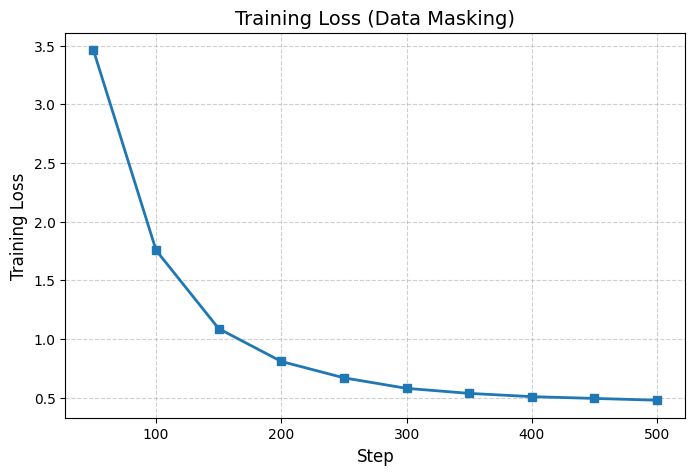

In [1]:
import matplotlib.pyplot as plt

# Data
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
train_losses = [3.4602, 1.7561, 1.0890, 0.8094, 0.6699, 0.5805, 0.5375, 0.5097, 0.4946, 0.4793]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, marker='s', linestyle='-', linewidth=2, markersize=6)

# Label and title
plt.title("Training Loss (Data Masking)", fontsize=14)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

In [12]:
from transformers import pipeline, logging
from tqdm import tqdm

# Disable warnings
logging.set_verbosity_error()

# Disable gradient checkpointing
model_clear.gradient_checkpointing_disable()

# Summarization pipeline
summarizer_clear = pipeline("summarization", model=model_clear, tokenizer=tokenizer, device=0)

# Test set
test_texts = [ex["full_note"] for ex in test_data]

# List to store the generated summaries
generated_summaries = []

# Progress bar with tqdm
for text in tqdm(test_texts, desc="Generating summary"):
    summary = summarizer_clear(
        text,
        max_length=512,
        min_length=400,
        truncation=True
    )[0]["summary_text"]
    generated_summaries.append(summary)

# Number of inferences
num_inferenze = len(generated_summaries)
print(f"Number of inferences: {num_inferenze}")

# Reference summaries
references = [ex["summary"] for ex in test_data]

Generating summary:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1636: UserWarning: Unfeasible length constraints: `min_length` (400) is larger than the maximum possible length (257). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Generating summary: 100%|██████████| 1000/1000 [55:08<00:00,  3.31s/it]


Number of inferences: 1000


In [13]:
generated_summaries[0]

'The patient was a **-ye**-ol* **** who presented with * sw****** ** the posterior surface of the proximal third of *** left leg. *** prior history included a prolonged stay in hospital for tr******* of bi******* en***********, when tw* me**** va*** re******** op******* were performed. ** had also previously undergone *** ab******* op******* to treat ** in******* tu*** and *** va****** ve*** su*****.Physical examination revealed * po******** ma** in the posterior region of the proximal third of the left leg. Femoral, popliteal, and dorsal pedal pulses were palpable and normal in both lower limbs. The posterior tibial artery pulse was absent, whereas the posterior tibial artery pulse was palpable in the right lower limb.Magnetic resonance angiography showed * st****** di********* ** th* ti********** tr*** with a *.* cm diameter, at the level of the origin of the posterior tibial artery. The posterior tibial artery was also occluded  . Investigation was supplemented with laboratory tests

In [20]:
# Evaluations
import evaluate

# ROUGE
rouge = evaluate.load("rouge")

results_clear = rouge.compute(predictions=generated_summaries, references=references)
print("ROUGE - Model on masked data:")
for k, v in results_clear.items():
    print(f"{k}: {v:.4f}")

ROUGE - Model on masked data:
rouge1: 0.6171
rouge2: 0.5438
rougeL: 0.5944
rougeLsum: 0.5943


In [17]:
# BLEU
bleu = evaluate.load("bleu")

references_bleu = [[ref] for ref in references]

results_bleu = bleu.compute(predictions=generated_summaries, references=references_bleu)

print(f"BLEU score: {results_bleu['bleu']:.4f}")

BLEU score: 0.2969


In [19]:
from bert_score import score

# BERTScore
P, R, F1 = score(generated_summaries, references, lang="en", verbose=True)

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 116.98 seconds, 8.55 sentences/sec
Precision: 0.9470
Recall: 0.8937
F1: 0.9195


In [ ]:
from statistics import mean

texts = [ex["summary"] for ex in train_data_clear]
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]
avg_tokens = mean(token_lengths)

print(f"Average token per entry in train set: {avg_tokens:.2f}")

Average token per entry in train set: 444.89
